In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from pandas.core.nanops import nanmean

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose, seasonal_mean
from statsmodels.tsa.stattools import ccf
from  statsmodels.tsa.filters.filtertools import convolution_filter as cf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
raw_data = pd.read_excel('sales.xlsx', parse_dates=['Date'], index_col='Date')

# 1. EDA

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2013-01-15 to 2016-08-15
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Units
 (Brand X)         44 non-null     int64  
 1   Sales, rub (Brand X)     44 non-null     int64  
 2   Category sales, rub      44 non-null     int64  
 3   Category units           44 non-null     int64  
 4   Non-TV spends (Brand X)  44 non-null     float64
 5   TRP (Brand X)            44 non-null     int64  
 6   TV spends  (Brand X)     44 non-null     float64
 7   TRP_Competitor_1         44 non-null     int64  
 8   TRP_Competitor_2         44 non-null     int64  
 9   TRP_Competitor_3         44 non-null     int64  
 10  TRP_Competitor_4         44 non-null     int64  
 11  TRP_Competitor_5         44 non-null     int64  
dtypes: float64(2), int64(10)
memory usage: 4.5 KB


In [9]:
raw_data.describe()

,Units\n (Brand X),"Sales, rub (Brand X)","Category sales, rub",Category units,Non-TV spends (Brand X),TRP (Brand X),TV spends (Brand X),TRP_Competitor_1,TRP_Competitor_2,TRP_Competitor_3,TRP_Competitor_4,TRP_Competitor_5
count,44.000000,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,44.000000,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000
mean,120164.295455,6.978781e+07,7.268466e+08,1.763233e+06,4.314235e+05,679.227273,1.274892e+07,281.022727,1167.136364,574.204545,124.613636,143.659091
std,36974.174548,2.006057e+07,1.271782e+08,2.672764e+05,8.032957e+05,648.642441,1.374341e+07,404.255646,804.164584,571.167535,401.588718,290.527103
min,54789.000000,3.462525e+07,3.690047e+08,1.215167e+06,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,84959.000000,5.202930e+07,6.668441e+08,1.585961e+06,0.000000e+00,0.000000,0.000000e+00,0.000000,625.000000,311.000000,0.000000,0.000000
50%,115649.000000,7.091354e+07,7.298773e+08,1.742190e+06,0.000000e+00,737.500000,1.010283e+07,0.000000,872.000000,443.000000,0.000000,0.000000
75%,155960.750000,8.602682e+07,7.976086e+08,1.932422e+06,5.019393e+05,1173.750000,2.215096e+07,468.000000,1650.500000,649.250000,0.000000,152.000000
max,197133.000000,1.176275e+08,1.018732e+09,2.413567e+06,3.540694e+06,2443.000000,4.634564e+07,1382.000000,3260.000000,3342.000000,1538.000000,1275.000000


In [13]:
new_columns = ['units_X', 'sales_X', 'cat_sales', 'cat_units', 'nontv_spends_X','trp_X', 'tv_spends_X'] + \
              [f'trp_{i}' for i in range(1, 6)]

In [14]:
new_columns

['units_X',
 'sales_X',
 'cat_sales',
 'cat_units',
 'nontv_spends_X',
 'trp_X',
 'tv_spends_X',
 'trp_1',
 'trp_2',
 'trp_3',
 'trp_4',
 'trp_5']

In [15]:
# подставляю более читаемые имена столбцов
raw_data = raw_data.rename({a: b for a, b in zip(raw_data.columns, new_columns)}, axis=1)

In [16]:
# для удобства, каждый месяц начинается с 1 числа
raw_data = raw_data.set_index(raw_data['units_X'].to_period('M').index.to_timestamp())

In [17]:
raw_data.head()

,units_X,sales_X,cat_sales,cat_units,nontv_spends_X,trp_X,tv_spends_X,trp_1,trp_2,trp_3,trp_4,trp_5
Date,,,,,,,,,,,,
2013-01-01,101010,52107917,369004673,1291598,0.000000e+00,526,4.332734e+06,790,571,96,0,0
2013-02-01,113758,58089497,436639366,1587868,0.000000e+00,437,5.658147e+06,500,274,337,0,0
2013-03-01,114979,59292688,479904035,1589302,0.000000e+00,720,1.151373e+07,285,641,396,0,0
2013-04-01,155589,79251686,627408870,1784739,2.323906e+06,1317,1.512565e+07,0,272,391,0,0
2013-05-01,167965,85757810,732761761,2089945,3.540694e+06,913,9.502889e+06,1078,842,444,0,0


Text(0, 0.5, '')

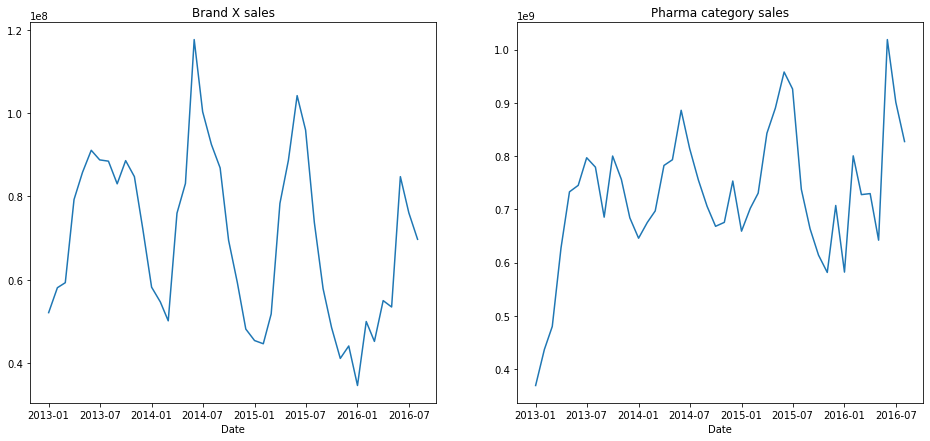

In [22]:
f, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.lineplot(y=raw_data['sales_X'], x=raw_data.index, ax=ax[0])
sns.lineplot(y=raw_data['cat_sales'], x=raw_data.index, ax=ax[1])
ax[0].set_title('Brand X sales')
ax[1].set_title('Pharma category sales')

ax[0].set_ylabel('')
ax[1].set_ylabel('')

Text(0, 0.5, '')

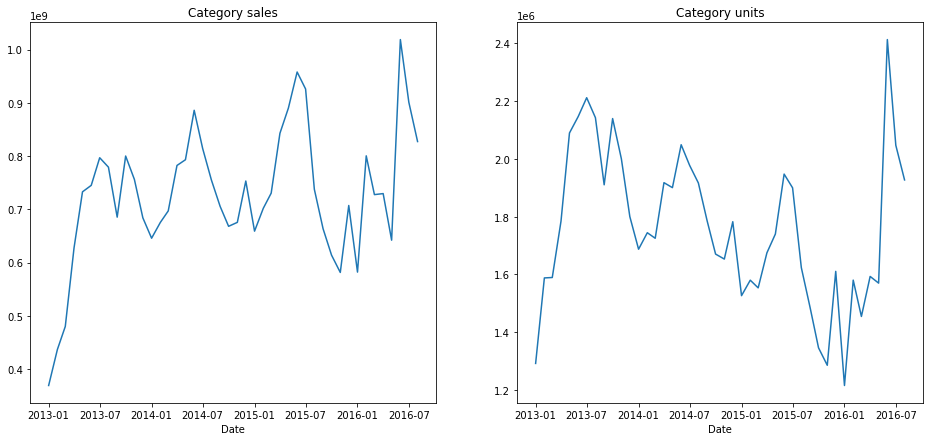

In [25]:
f1, ax1 = plt.subplots(1, 2, figsize=(16, 7))
sns.lineplot(y='cat_sales', x=raw_data.index, ax=ax1[0], data=raw_data)
sns.lineplot(y='cat_units', x=raw_data.index, ax=ax1[1], data=raw_data)

ax1[0].set_title('Category sales')
ax1[1].set_title('Category units')

ax1[0].set_ylabel('')
ax1[1].set_ylabel('')

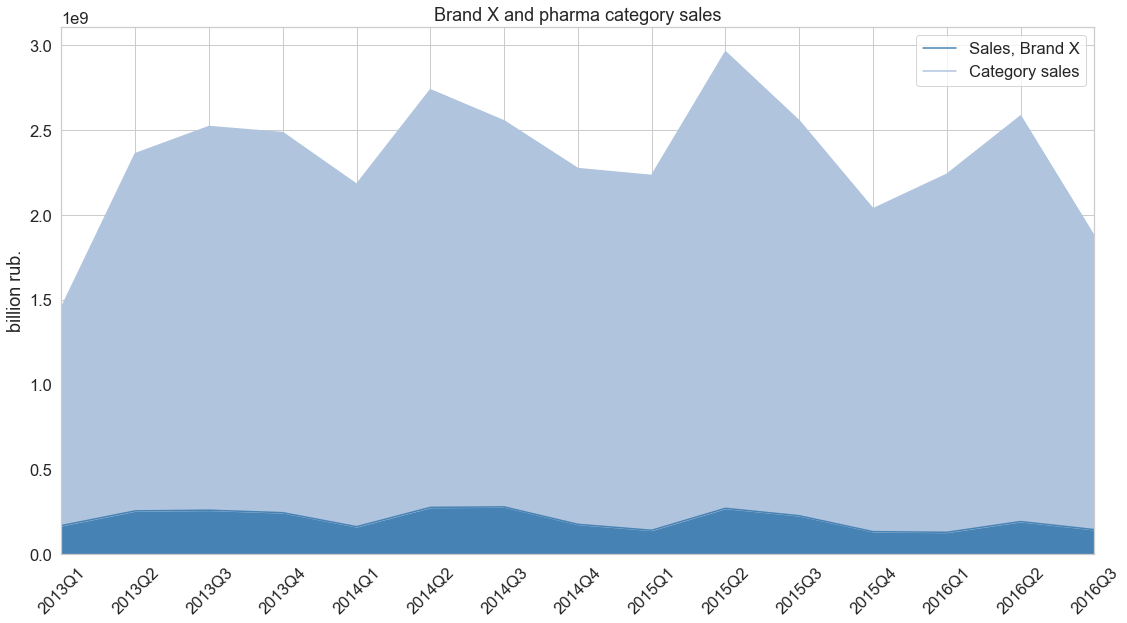

In [28]:
sns.set(font_scale=1.5, style='whitegrid')
f, ax = plt.subplots(figsize=(16, 9))
quarter = raw_data.resample('Q').agg('sum')[['sales_X', 'cat_sales']].to_period('Q')
quarter.plot.area(ax=ax, color=('steelblue', 'lightsteelblue'))
ax.set_xticks(quarter.index)
ax.set_xticklabels(quarter.index, rotation=45)
ax.legend(['Category sales', 'Sales, Brand X'][::-1])
ax.set_xlabel('')
ax.set_ylabel('billion rub.')
ax.set_title('Brand X and pharma category sales')

plt.tight_layout()
plt.show()
# plt.savefig('area_sales.svg')

<ipython-input-29-fa9b607e92f6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [f'{x:.0f}%' for x in ax.get_yticks()][1:])


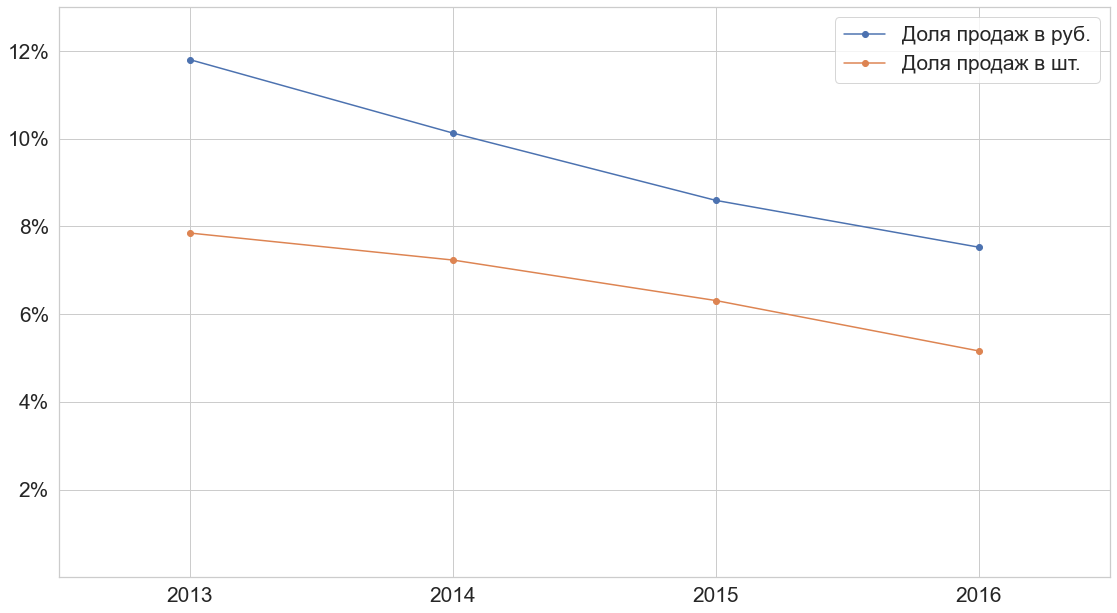

In [29]:
sns.set(font_scale=1.9, style='whitegrid')
f, ax = plt.subplots(figsize=(16, 9))
yearly = raw_data.resample('Y').agg('sum').to_period('Y')
(yearly['sales_X'] / yearly['cat_sales'] * 100).plot(ax=ax, label='Доля продаж в руб.', marker='o')

(yearly['units_X'] / yearly['cat_units'] * 100).plot(ax=ax, label='Доля продаж в шт.', marker='o')
ax.set_ylim(0, 13)
ax.set_xlim(42.5, 46.5)
ax.set_yticklabels([''] + [f'{x:.0f}%' for x in ax.get_yticks()][1:])
ax.legend()
ax.set_xlabel('')
plt.tight_layout()
# plt.savefig('share.svg')


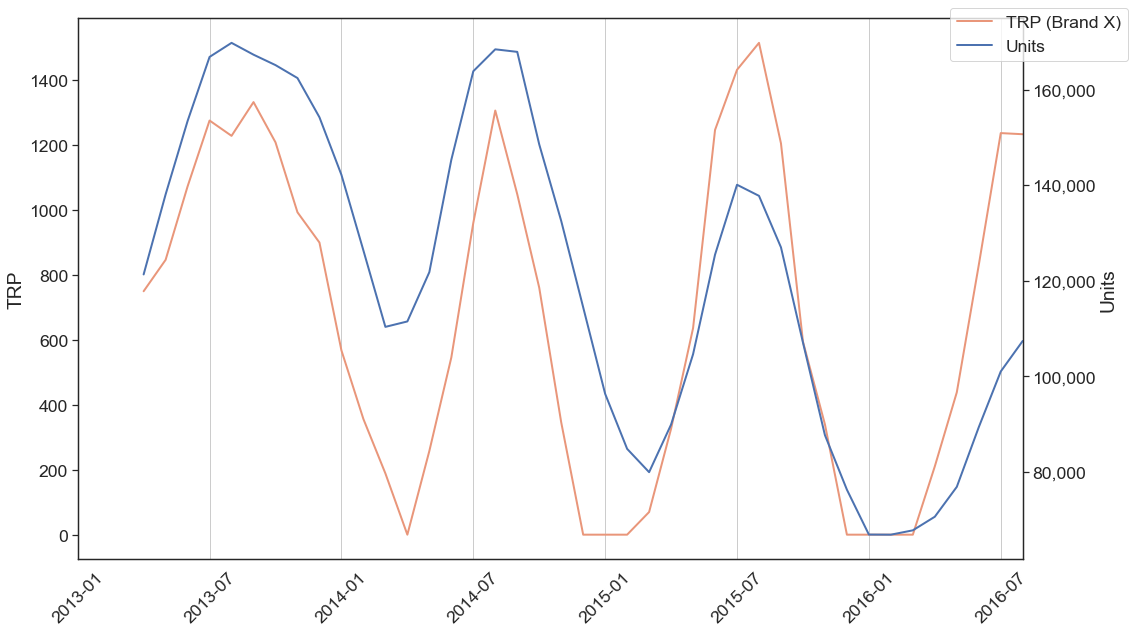

In [30]:
sns.set(style='white', font_scale=1.6)
f, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()
(raw_data.to_period('M')['trp_X'].rolling(4).mean()).plot(ax=ax, color='darksalmon', label='TRP (Brand X)', linewidth=2)
raw_data.to_period('M')['units_X'].rolling(4).mean().plot(ax=ax2, label='Units', linewidth=2)
ax.set_xticks(raw_data.to_period('M').index[::6])
ax.set_xticklabels(raw_data.to_period('M').index[::6], rotation=45)
ax.xaxis.grid()
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('TRP')
ax2.set_ylabel('Units')
ax.set_xlabel('')
f.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('trp_units.svg')

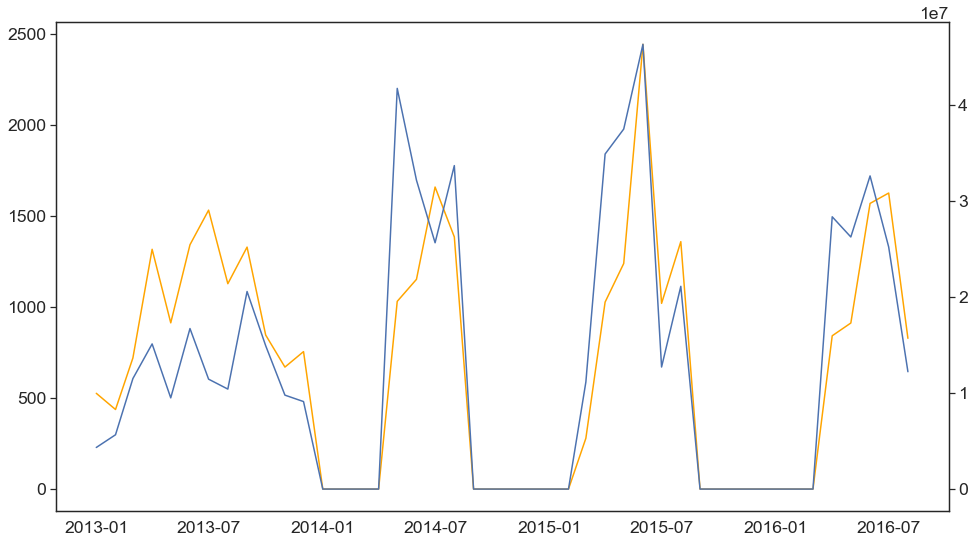

In [36]:
f, ax = plt.subplots(figsize=(16, 9))
ax1 = ax.twinx()
ax.plot(raw_data['trp_X'], c='orange')
ax1.plot(raw_data['tv_spends_X'])

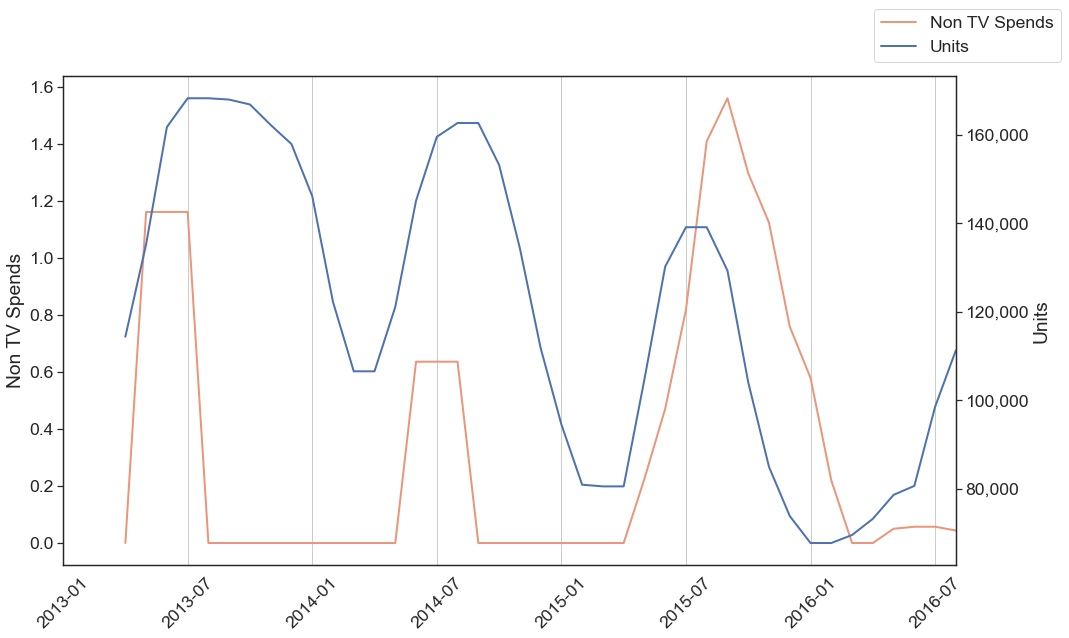

In [35]:
sns.set(style='white', font_scale=1.6)
f, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()
(raw_data.to_period('M').rolling(window=4).median()['nontv_spends_X'] / 1e6).plot(ax=ax,
                                                                                  color='darksalmon',
                                                                                  label='Non TV Spends', 
                                                                                  linewidth=2)
raw_data.to_period('M').rolling(window=4).median()['units_X'].plot(ax=ax2, label='Units', linewidth=2)
ax.set_xticks(raw_data.to_period('M').index[::6])
ax.set_xticklabels(raw_data.to_period('M').index[::6], rotation=45)
ax.xaxis.grid()
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Non TV Spends')
ax2.set_ylabel('Units')
ax.set_xlabel('')
f.legend(loc='upper right')
# plt.savefig('nontvspends.svg')

<AxesSubplot:label='e696f68c-dcc8-46a6-a6e8-b20956d7c1e6', xlabel='Date'>

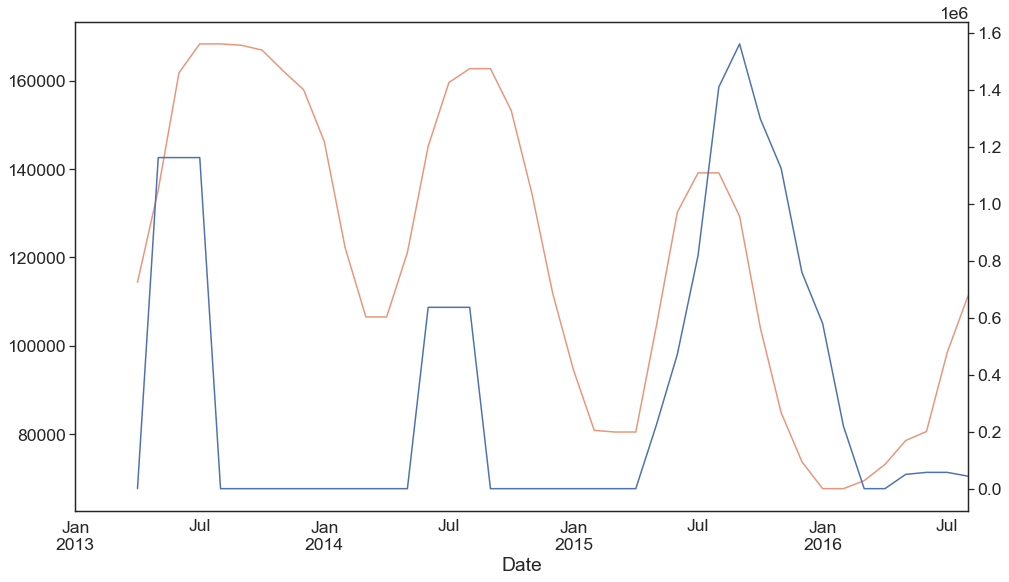

In [16]:
f, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()
raw_data.rolling(window=4).median()['units_X'].plot(ax=ax, color='darksalmon')
raw_data.rolling(window=4).median()['nontv_spends_X'].plot(ax=ax2)

<AxesSubplot:label='2eabac9e-95ea-4c2f-88c3-cbace30797a7', xlabel='Date'>

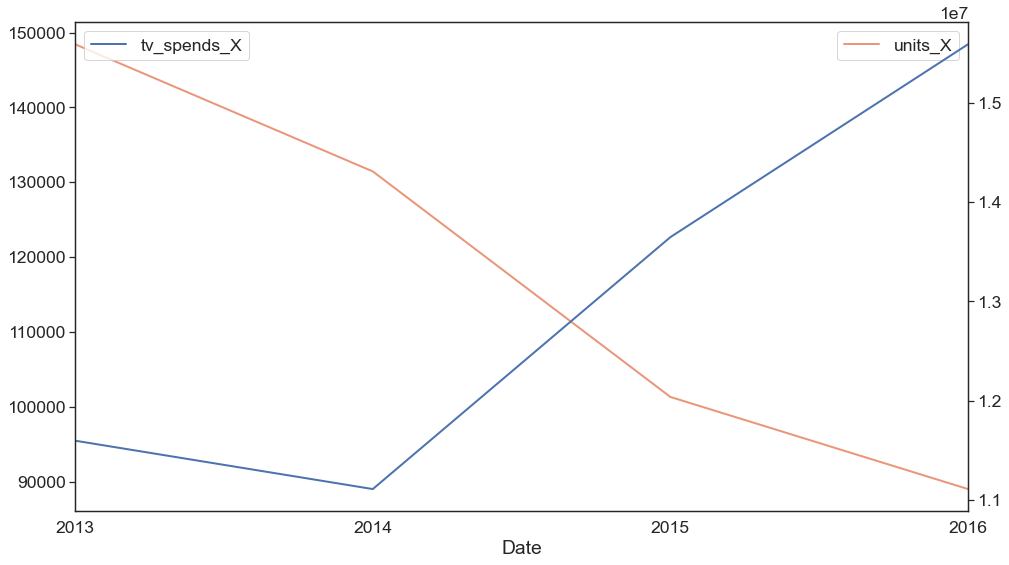

In [39]:
f, ax = plt.subplots(figsize=(16, 9))
ax1 = ax.twinx()
raw_data.resample('Y').agg('mean')[['units_X']].plot(ax=ax, color='darksalmon', lw=2)
raw_data.resample('Y').agg('mean')[['tv_spends_X']].plot(ax=ax1, lw=2)

In [40]:
# Pearson correlation matrix
raw_data.corr()

,units_X,sales_X,cat_sales,cat_units,nontv_spends_X,trp_X,tv_spends_X,trp_1,trp_2,trp_3,trp_4,trp_5
units_X,1.000000,0.946511,0.412843,0.800727,0.255402,0.675609,0.505704,0.617332,0.048873,-0.009684,-0.181015,0.451919
sales_X,0.946511,1.000000,0.611799,0.795460,0.282313,0.767340,0.655813,0.535788,0.287084,0.148172,-0.059527,0.590164
cat_sales,0.412843,0.611799,1.000000,0.685583,0.131577,0.522833,0.559272,0.134030,0.639423,0.434767,0.202026,0.413332
cat_units,0.800727,0.795460,0.685583,1.000000,0.078827,0.639765,0.458152,0.479459,0.319973,0.278112,0.126679,0.299175
nontv_spends_X,0.255402,0.282313,0.131577,0.078827,1.000000,0.298641,0.272365,0.136190,0.071997,-0.027893,-0.100070,0.213312
trp_X,0.675609,0.767340,0.522833,0.639765,0.298641,1.000000,0.849712,0.396094,0.513305,0.343811,0.260532,0.523371
tv_spends_X,0.505704,0.655813,0.559272,0.458152,0.272365,0.849712,1.000000,0.178206,0.555619,0.344913,0.348346,0.371746
trp_1,0.617332,0.535788,0.134030,0.479459,0.136190,0.396094,0.178206,1.000000,-0.044242,-0.106885,-0.220726,0.457724
trp_2,0.048873,0.287084,0.639423,0.319973,0.071997,0.513305,0.555619,-0.044242,1.000000,0.593174,0.511043,0.346721
trp_3,-0.009684,0.148172,0.434767,0.278112,-0.027893,0.343811,0.344913,-0.106885,0.593174,1.000000,0.448544,0.026304


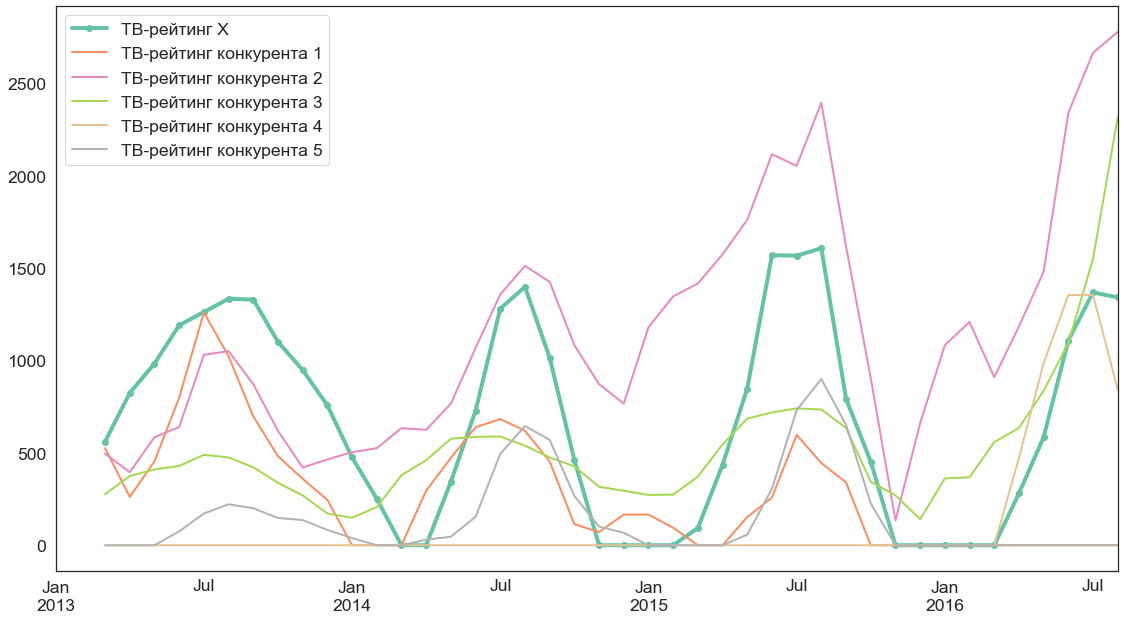

In [19]:
sns.set(font_scale=1.6, style='white')
f, ax = plt.subplots(figsize=(16, 9))
raw_data.iloc[:, -7:].drop(['tv_spends_X'], axis=1).rolling(3).mean().plot(ax=ax, colormap='Set2', 
                                                                          style=['-o'] + ['-'] * 5)

lws = [4, 2, 2, 2, 2, 2]
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i])
    
ax.legend(['ТВ-рейтинг X'] + ['ТВ-рейтинг конкурента ' + str(x) for x in range(1, 6)])
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('trp_comp.svg')

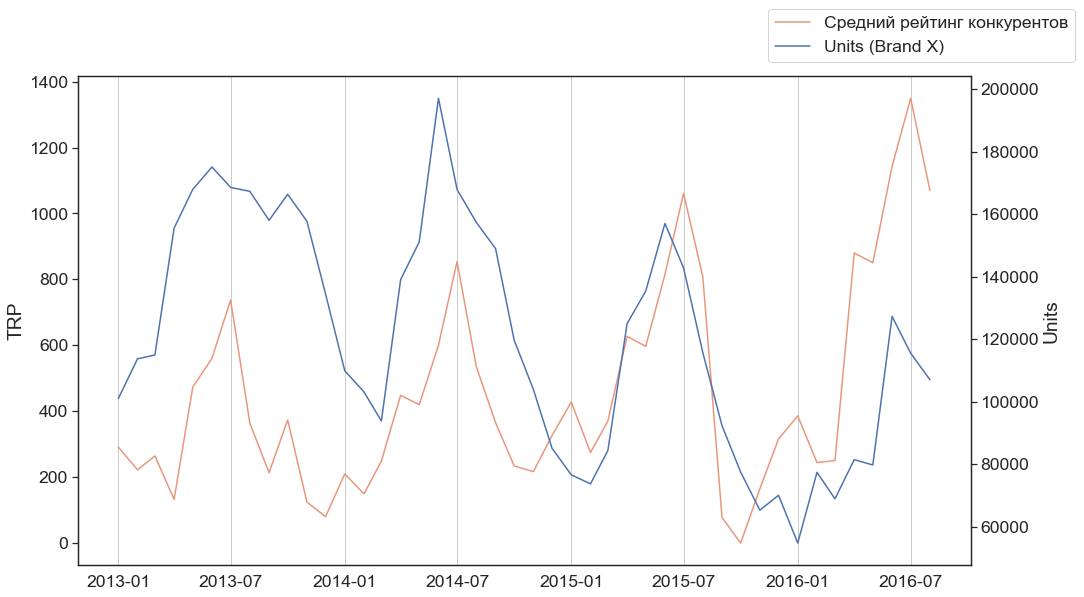

In [41]:
sns.set(style='white', font_scale=1.6)
f, ax = plt.subplots(figsize=(16, 9))
ax1 = ax.twinx()
ax.plot(raw_data.iloc[:, -5:].mean(axis=1), color='darksalmon', label='Средний рейтинг конкурентов')
ax.set_ylabel('TRP')
ax1.plot(raw_data['units_X'], label='Units (Brand X)')
ax1.set_ylabel('Units')
ax.xaxis.grid()
f.legend()
# plt.tight_layout()
# plt.savefig('trpcomp_units.svg')

In [44]:
raw_data['price'] = (raw_data['sales_X'] / raw_data['units_X']).round(1)

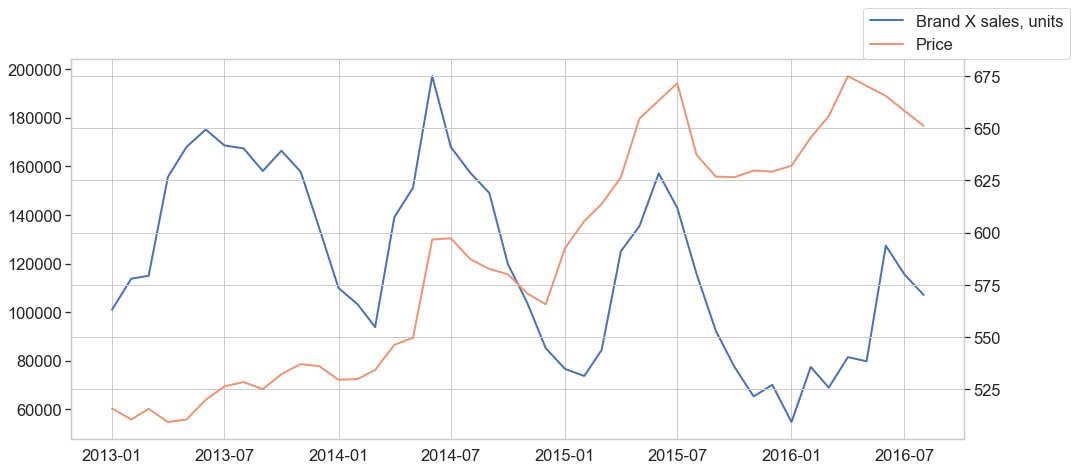

In [51]:
sns.set(style='whitegrid', font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 7))
ax1 = ax.twinx()
ax.plot(raw_data['units_X'], label='Brand X sales, units', lw=2)
ax1.plot(raw_data['price'], color='darksalmon', label='Price', lw=2)
ax.yaxis.grid()
f.legend()

In [57]:
plan = pd.Series([5777, 5500], index=pd.date_range('01/01/2016', periods=2, freq='Y').to_period('Y'))

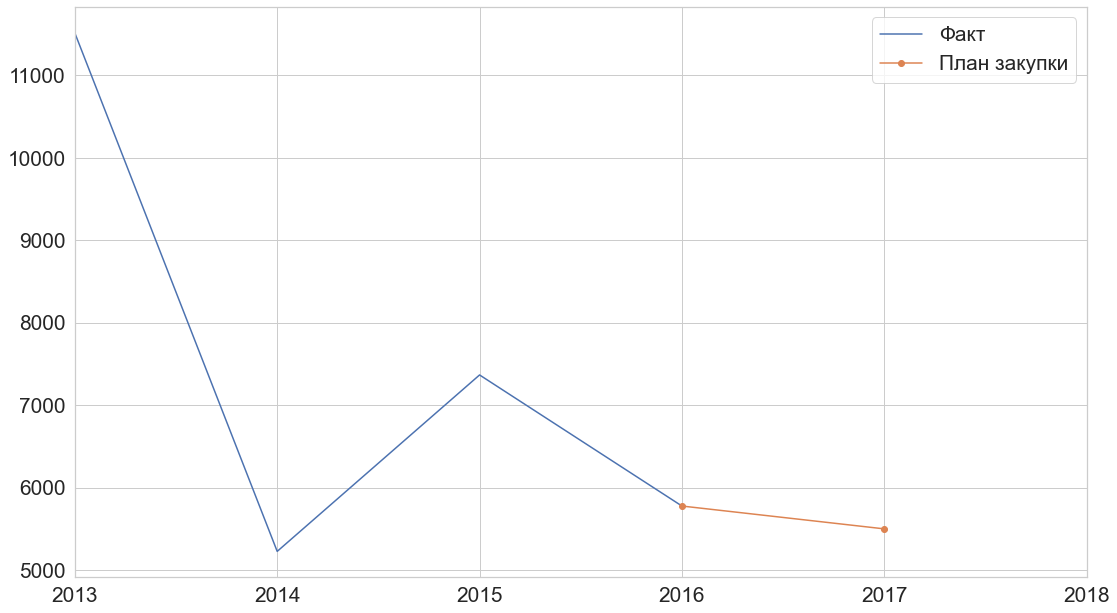

In [58]:
sns.set(style='whitegrid', font_scale=1.9)
plt.figure(figsize=(16, 9))
raw_data['trp_X'].resample('Y').sum().to_period('Y').plot(label='Факт')
plan.plot(style='-o', label='План закупки')
plt.xticks(range(43, 49))
plt.legend()
plt.xlabel('')
plt.tight_layout()
# plt.savefig('trp_forec.svg');

# 2. Time Series Analysis

In [60]:
s = seasonal_decompose(raw_data['units_X'], period=12, model='additive')

In [61]:
v = seasonal_decompose(raw_data['trp_X'], period=12, model='additive')

Text(0.5, 0.98, 'TV-ratings time series decomposition')

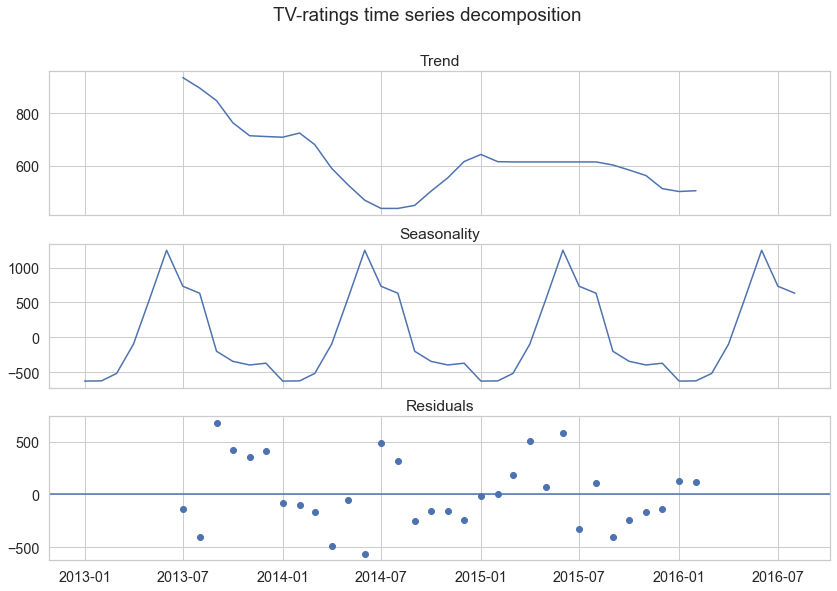

In [67]:
sns.set(font_scale=1.3, style='whitegrid')
f, ax = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
ax[0].plot(v.trend)
ax[0].set_title('Trend')
ax[1].plot(v.seasonal)
ax[1].set_title('Seasonality')
ax[2].plot(v.resid, 'o')
ax[2].set_title('Residuals')
ax[2].axhline(0)
f.suptitle('TV-ratings time series decomposition')
# plt.savefig('trpdecomp.svg')

Text(0.5, 0.98, 'Sales in units time series decomposition')

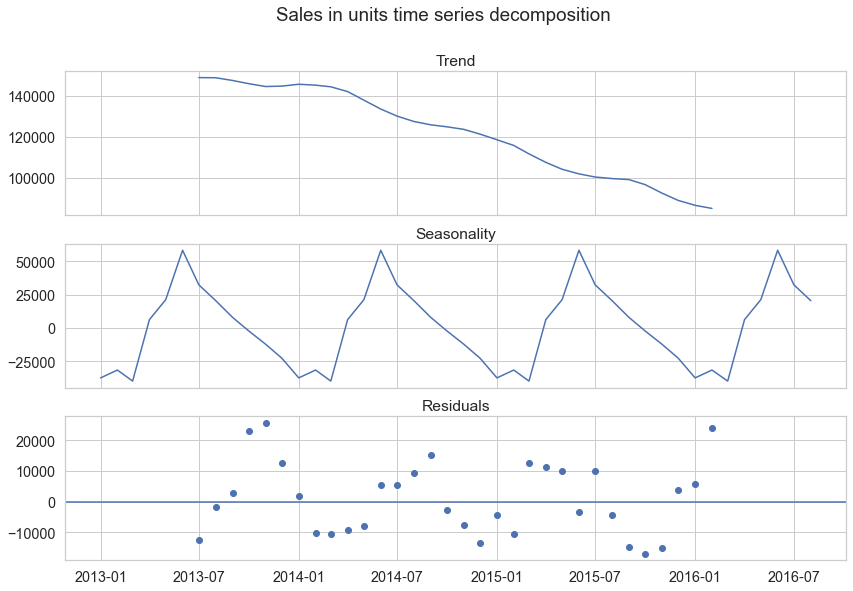

In [68]:
sns.set(font_scale=1.3, style='whitegrid')
f, ax = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
ax[0].plot(s.trend)
ax[0].set_title('Trend')
ax[1].plot(s.seasonal)
ax[1].set_title('Seasonality')
ax[2].plot(s.resid, 'o')
ax[2].set_title('Residuals')
ax[2].axhline(0)
f.suptitle('Sales in units time series decomposition')
# plt.savefig('unitsdec.svg')

In [69]:
# кросс-корреляция с лагом -5
s.resid.corr(v.resid.shift(-5))

-0.48719904758015226

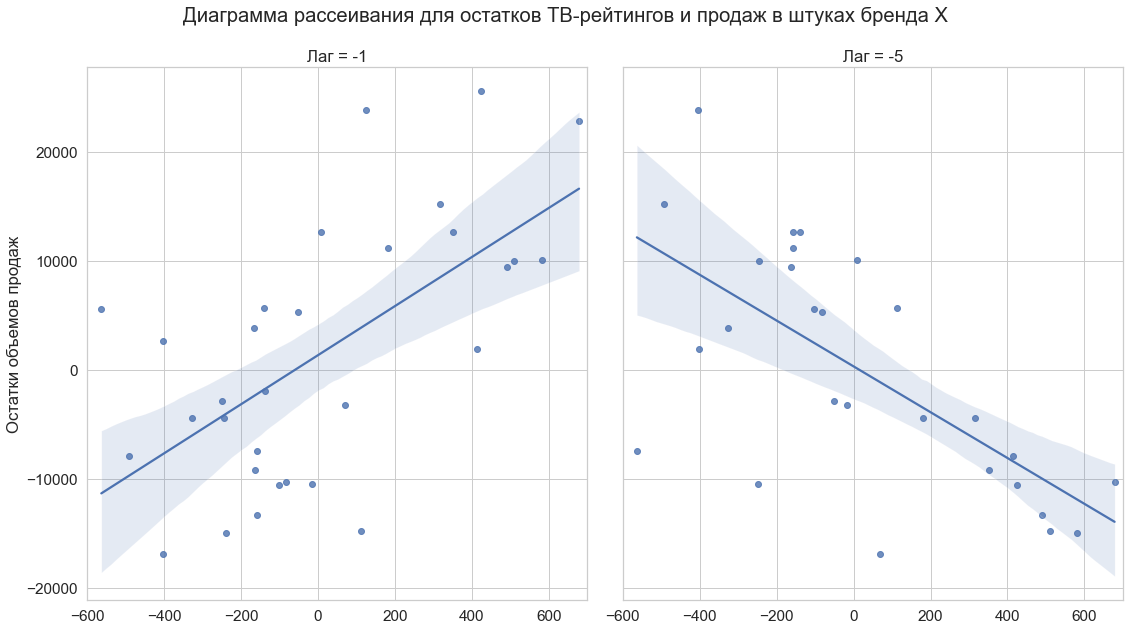

In [71]:
sns.set(font_scale=1.4, style='whitegrid')
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
sns.regplot(x=v.resid.shift(1), y=s.resid, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Остатки объемов продаж')
ax[0].set_xlim(-600, 700)
ax[0].set_title('Лаг = -1')

sns.regplot(x=v.resid.shift(5), y=s.resid, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_xlim(-600, 700)
ax[1].set_title('Лаг = -5')
ax[1].set_ylabel('')
f.suptitle('Диаграмма рассеивания для остатков ТВ-рейтингов и продаж в штуках бренда X')
plt.tight_layout()
# plt.savefig('corr_trp.svg')

In [29]:
v.resid.shift(1).corr(s.resid)

0.6245461267828177

## Наивный сезонный прогноз

Наивный прогноз - значение в следующем месяце равно среднему из значений в этом же месяце за предыдущие годы

In [73]:
units = raw_data['units_X']
n = len(units)

# разбиваю выборку с соотношении 80% на 20% 
split_index = int(n * 0.8)
train = units[:split_index]
test = units[split_index:]
test_months = test.index.month
print(len(train), len(test))

35 9


In [75]:
predictions = pd.Series(train.groupby(train.index.month).mean().loc[test_months].values, index=test.index)

In [76]:
rmse = np.sqrt(mean_squared_error(test.values, predictions.values))

In [77]:
mape = sum(abs((test.to_numpy() - predictions.to_numpy()) / test.to_numpy())) / len(predictions)

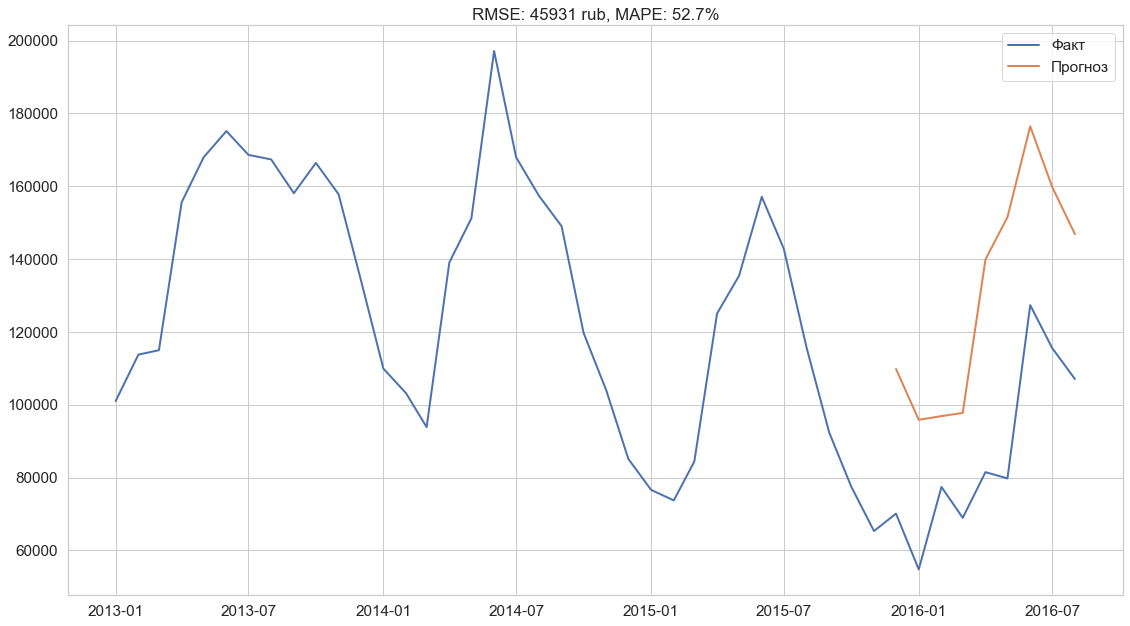

In [78]:
plt.figure(figsize=(16, 9))
plt.plot(units, label='Факт', lw=2)
plt.plot(predictions, label='Прогноз', lw=2)
plt.title(f'RMSE: {rmse:.0f} rub, MAPE: {mape:.1%}')
plt.tight_layout()
plt.legend()
# plt.savefig('naiveseas.svg')

### Визуализация прогнозов модели (см. скрипт в RStudio)

In [39]:
arima_pred = pd.Series([52346.11, 47219.92, 46424.81, 89692.95, 101057.17, 136671.85, 113855.67 , 96272.66], 
         index=raw_data.index[raw_data.index >= '2016-01-01'])

In [40]:
lower_80 = [ float(x) for x in '33789.781 20977.307 14284.300 52580.287 59563.951 91218.310 64760.230 43787.428'.split()]

In [41]:
lower_95 = [ float(x) for x in '23966.652  7085.305 -2729.858 32934.030 37598.767 67156.656 38770.674 16003.424'.split()]

In [42]:
upper_80 = [ float(x) for x in '70902.44  73462.54  78565.32 126805.62 142550.39 182125.40 162951.11 148757.89'.split()]
upper_95 = [ float(x) for x in '80725.57  87354.54  95579.48 146451.87 164515.57 206187.05 188940.67 176541.90'.split()]

In [44]:
arima_rmse = np.sqrt(mean_squared_error(arima_pred.values, units[units.index >= '2016-01-01']))
arima_mape = sum(abs((units[units.index >= '2016-01-01'] - arima_pred.values) / units[units.index >= '2016-01-01'])) / len(arima_pred)

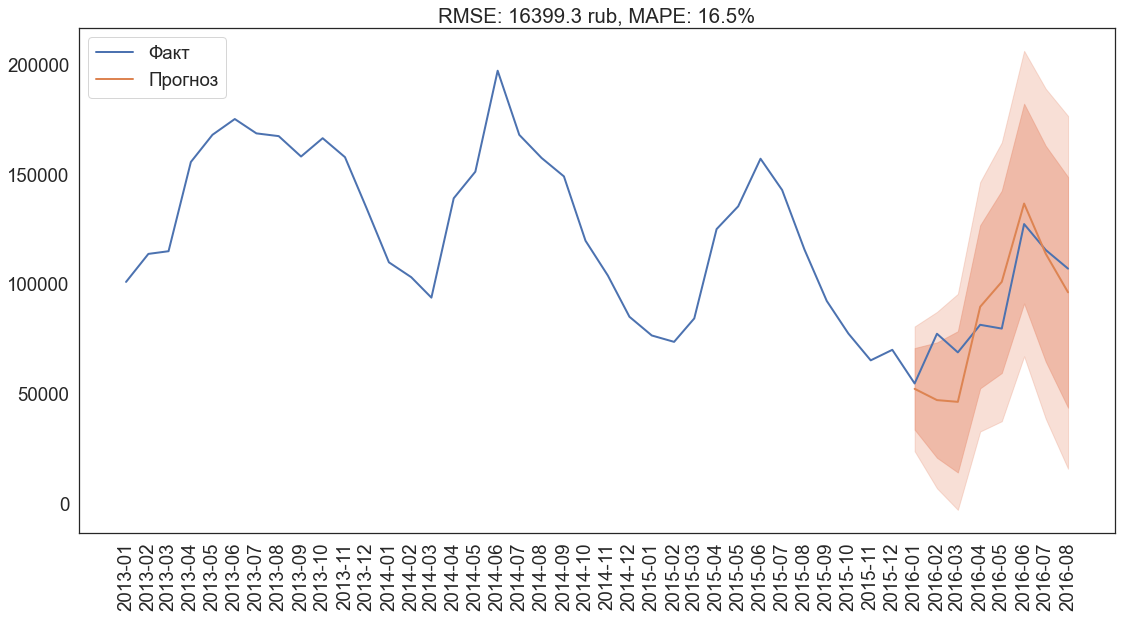

In [45]:
sns.set(style='white', font_scale=1.7)
plt.figure(figsize=(16, 9))
plt.plot(units, lw=2, label='Факт')
plt.plot(arima_pred, lw=2, label='Прогноз')
plt.legend()
plt.title(f'RMSE: {arima_rmse:.1f} rub, MAPE: {arima_mape:.1%}')
plt.tight_layout()
plt.xticks(units.index, units.index.to_period('M'), rotation=90)
plt.legend(loc='upper left')
plt.fill_between(x=plt.xticks()[0][-8:], y1=lower_80, y2=upper_80, color='darksalmon', alpha=0.5)
plt.fill_between(x=plt.xticks()[0][-8:], y1=lower_95, y2=upper_95, color='darksalmon', alpha=0.3)
plt.tight_layout()
# plt.savefig('arimaforec.svg');

In [80]:
# d = np.zeros((5, 16))

# for i in range(5): 
#     d[i] = [float(x.replace(',', '.')) for x in input().split()]

# dates = pd.date_range('2016-09-01', '2018-01-01', freq='M')

# sns.set(style='whitegrid', font_scale=1.7)
# plt.figure(figsize=(16, 9))
# plt.plot(units, lw=2)
# plt.plot(pd.Series(d[0], index=dates), lw=2)
# plt.fill_between(x=dates, y1=d[1], y2=d[2], color='darksalmon', alpha=0.5)
# plt.fill_between(x=dates, y1=d[3], y2=d[4], color='darksalmon', alpha=0.3)
# plt.tight_layout()
# # plt.savefig('final_forecast.svg')

ValueError: cannot copy sequence with size 0 to array axis with dimension 16